# Write Database

In [1]:
import os
import cv2
import lmdb
from random import Random
from matplotlib import pyplot as plt
from psutil import virtual_memory
import click
import time
from glob import glob
import numpy as np
import math

In [2]:
def writeFileList(dirNameArr):
    """
    Returns the python list object of the files under a directory name for processing later
    """
    '''
    if isinstance(dirNameArr, basestring): # someone only inputed a single string, so make it a list so that this code works

        dirNameArr = [dirNameArr]
    '''
    dirNameArr = [dirNameArr]
    files_list = [] # list of all files with full path
    for dirName in dirNameArr: 
    # loop through all files in the list of directory names inputted. This is useful for multiple datasets	
        with click.progressbar(os.walk(dirName), label="Parsing files in "+dirName) as bar:
            for dirname, dirnames, filenames in bar:
                for filename in filenames:
                    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg') or filename.endswith('.bmp') or filename.endswith('.tiff'):	
                        fileName = glob(os.path.join(dirname, filename)) 
                        files_list += fileName
 
    return files_list

In [3]:
def randPerspectiveWarp(im, w, h, r, ret_pts=False):

    """
    Applies a pseudo-random perspective warp to an image. 

    input: 

    im - the original image

    h - image height
    
    w - image width

    r - Random instance

    returns:

    im_warp - the warped image

    ret_pts - if True, return the points generated 
    """ 

    # Generate two pseudo random planes within tolerances for the projective transformation of the original image
    # Each point is from the center half of its respective x y quandrant. openCV getPerpectiveTransform expects [Q2, Q3, Q1, Q4] for points in each image quandrant, so that it 
    # the iteration order here. Note that 0,0 is the top left corner of the picture. Additionally, we can only perform a tranformation to zoom in, since exprapolated pixels
    # look unnatural, and will ruin the similarity between the two images.

    # limits for random number generation
    minsx = [ 0, 3*w/4 ]
    maxsx = [ w/4, w ]
    minsy= [ 0, 3*h/4 ]
    maxsy = [ h/4, h ]


    pts_orig = np.zeros((4, 2), dtype=np.float32) # four original points
    pts_warp = np.zeros((4, 2), dtype=np.float32) # points for the affine transformation. 

    # fixed point for the first plane	
    pts_orig[0, 0] = 0
    pts_orig[0, 1] = 0
    
    pts_orig[1, 0] = 0
    pts_orig[1, 1] = h

    pts_orig[2, 0] = w
    pts_orig[2, 1] = 0

    pts_orig[3, 0] = w
    pts_orig[3, 1] = h

    # random second plane
    pts_warp[0, 0] = r.uniform(minsx[0], maxsx[0])
    pts_warp[0, 1] = r.uniform(minsy[0], maxsy[0])
    
    pts_warp[1, 0] = r.uniform(minsx[0], maxsx[0])
    pts_warp[1, 1] = r.uniform(minsy[1], maxsy[1])

    pts_warp[2, 0] = r.uniform(minsx[1], maxsx[1])
    pts_warp[2, 1] = r.uniform(minsy[0], maxsy[0])

    pts_warp[3, 0] = r.uniform(minsx[1], maxsx[1])
    pts_warp[3, 1] = r.uniform(minsy[1], maxsy[1])

    # compute the 3x3 transform matrix based on the two planes of interest
    T = cv2.getPerspectiveTransform(pts_warp, pts_orig)

    # apply the perspective transormation to the image, causing an automated change in viewpoint for the net's dual input
    im_warp = cv2.warpPerspective(im, T, (w, h))
    if not ret_pts:
        return im_warp
    else: 
        return im_warp, pts_warp


In [4]:
def showImWarpEx(im_fl, save):
    """
    Show an example of warped images and their corresponding four corner points.
    """

    im = cv2.resize(cv2.cvtColor(cv2.imread(im_fl), cv2.COLOR_BGR2GRAY), (256,int(120./160*256)))
    r = Random(0)
    r.seed(time.time())
    h, w = im.shape
    im_warp, pts_warp = randPerspectiveWarp(im, w, h, r, ret_pts=True) # get the perspective warped picture	

    pts_orig = np.zeros((4, 2), dtype=np.float32) # four original points
    ofst = 3
    pts_orig[0, 0] = ofst
    pts_orig[0, 1] = ofst
    pts_orig[1, 0] = ofst
    pts_orig[1, 1] = h-ofst
    pts_orig[2, 0] = w-ofst
    pts_orig[2, 1] = ofst
    pts_orig[3, 0] = w-ofst
    pts_orig[3, 1] = h-ofst

    kpts_warp = []
    kpts_orig = []
    matches = []

    pts_rect = np.zeros((4, 2), dtype=np.float32) # for creating rectangles
    pts_rect[0, 0] = w/4
    pts_rect[0, 1] = h/4
    pts_rect[1, 0] = w/4
    pts_rect[1, 1] = 3*h/4
    pts_rect[2, 0] = 3*w/4
    pts_rect[2, 1] = h/4
    pts_rect[3, 0] = 3*w/4
    pts_rect[3, 1] = 3*h/4
    if save: # save orig before placing rectangles on it
        cv2.imwrite("Original.jpg", im)

    for i in range(4):
        kpts_warp.append(cv2.KeyPoint(pts_warp[i,0], pts_warp[i,1], 0))
        kpts_orig.append(cv2.KeyPoint(pts_orig[i,0], pts_orig[i,1], 0))
        matches.append(cv2.DMatch(i,i,0))
        im = cv2.rectangle(im, (pts_orig[i,0], pts_orig[i,1]), (pts_rect[i,0], pts_rect[i,1]), (255,255,255), thickness=2)	
    draw_params = dict(matchColor=(0,0,250),flags = 4)
    out_im = cv2.drawMatches(im, kpts_warp, im_warp, kpts_orig, matches, None, **draw_params)
    plots = os.path.join(os.getcwd(), "plots")
    from matplotlib import rcParams
    rcParams['savefig.directory'] = plots
    if not os.path.isdir(plots):
        os.makedirs(plots)
    plt.imshow(out_im)
    plt.axis('off')
    plt.show()
    if save:
        cv2.imwrite("Warped.jpg", im_warp)
        print ("Images saved in current directory")

In [5]:
def calcNumBuff(w, h, n, n_comp, mem):
    """ 
    calculate the minimum number of buffers to use based on the capacity of system ram and gpu memory
    """

    # calculate the number of buffers to use based on the data size and the available RAM
    # Additionally, only use about 7/8 of RAM for buffers dues to other overheads (mainly from PCA), and add 1 extra buffer in case the calculated number is zero

    # RAM in bytes
    ram_mem = mem.available

    bytePerFloat = 4
    bytePerInt = 1

    # images are uint8, descriptors are floats
    bytesInRAMFromData = int( n * (n_comp * bytePerFloat + w*h*bytePerInt) )

    min_buff_ram = 1 + int( 3.0 * bytesInRAMFromData / ram_mem / 4.0) # min number of buffers to take up a little less than 75% RAM per buffer, plus one in case it's zero

    # return the max number of buffers out of the two so that we dont overload either RAM or GPU memory. This makes this code portable to other machines, but the results will vary
    return min_buff_ram, bytesInRAMFromData

In [6]:
def decideWaitForMem(initBytesNeeded, percentDone, mem):
    '''
    Return true if need to wait for more memory. Return false otherwise
    '''
    needWaitForMem = False	
    if (1.0 - percentDone) * initBytesNeeded > mem.available: # note that percent done is in [0,1]
        needWaitForMem = True

    return needWaitForMem

In [7]:
from sys import platform
print(platform)

mem = virtual_memory()
print(mem)

win32
svmem(total=16989859840, available=7790821376, percent=54.1, used=9199038464, free=7790821376)


In [8]:
def writeDatabase(outDBNames, files_list, w, h, data_root="", prev_model_basename="", test_db=False, debugFlag=False):

    """
    Creates two tensors of image matrices. The images are read from the filenames in files_list, resized, converted to grayscale if they are color.
    The images are shuffled to avoid statistical issues with caffe, then randomly swapped.
    X1 contains just images from each pair, and X2 contains HOG descriptors from the other image of each pair 
    The end product is created in buffers and written to two LMDBs for X1 and X2 accordingly
    """

    if (not data_root=="") and (not data_root.endswith('\\')): # expect directory name to have '/' appended
        #print(data_root)
        data_root += '\\'
    #print(data_root)
    #if not 'linux' in platform:
    #    raise Exception('Error: only UNIX machines are currently supported')

    print ('\npreparing to transform images and write databases ...\n') 

    n = len(files_list) # number of samples

    n_comp = 3648 # HOG vector length

    mem = virtual_memory()
    num_buff, bytesNeeded = calcNumBuff(w, h, n, n_comp, mem) # number of buffers for database writing
    if debugFlag:
        num_buff = 3
        bytesNeeded = 0
                
    n_per_buff = int(math.ceil(n/num_buff)) 
    print ("Number of buffers: ", num_buff, ", Images per buffer: ", n_per_buff, ", Total image count: " + str(n) + '\n\n\n\n\n\n\n')
    data_size_per_img = cv2.imread(files_list[0],cv2.IMREAD_UNCHANGED).nbytes
    r = Random(0) # make a random number generator instance seeded with 0	
    if test_db:
        plt.ion()
    inds = list(range(n))
    # shuffling indices will slow down the array accessing process,
    # but will take away any relationship between adjacent images, making the model better
    r.shuffle(inds) # note that shuffle works in place
    if not os.path.isdir(data_root+"train_data"):
        os.makedirs(data_root+"train_data")
    # prepare the max database size. There is no harm in making it too big, since this is only the cap, not the actual size. If disk space runs out, it will throw an error and crash anyways
    #map_size = 20*1024**3 # 20GB
    #print(data_size_per_img)
    map_size = 5*data_size_per_img*n
    #print(n)
    #print(map_size)
    chan = 1
    first_buff_flag = True
    im_count_tot = 0 # total number of pictures
    i_to_show = r.randint(0,n_per_buff-1)
    hog = cv2.HOGDescriptor((16, 32), (16,16), (16,16), (8,8), 2,1)	
    X1_db_name = data_root + "train_data\\" + outDBNames[0]
    X2_db_name = data_root + "train_data\\" + outDBNames[1]
    #print(X1_db_name)

    with click.progressbar(range(num_buff), label="Total Progress") as bigBar:
        for j in bigBar:
            ##### Database writing #################################
            db1 = lmdb.open(X1_db_name, map_size=map_size)
            db2 = lmdb.open(X2_db_name, map_size=map_size)
            #db1 = lmdb.open('live', map_size=map_size)
            #db2 = lmdb.open('memory', map_size=map_size)
            k = 0 # index in X row
            txn1 = db1.begin(write=True, buffers=True) # start a new transaction for the database
            txn2 = db2.begin(write=True, buffers=True)
            with click.progressbar(inds[(j*n_per_buff):((j+1)*n_per_buff)], label=("Progress in buffer "+str(j+1)+" out of " + str(num_buff))) as bar:
                resolutions = []
                for i in bar: # index in files_list, which is n long
                    im_file = files_list[i]
                    im = cv2.imread(im_file)
                    while im is None: # Some images get corrupted sometimes. Check for this so that it doesnt crash a multi-day running process (sigh)
                        print ("\n\n\nSkipping corrupted image:",im_file, ". Bootstrapping random image from dataset\n\n\n")
                        im_file = files_list[r.randint(0, n-1)]
                        im = cv2.imread(im_file)

                    if len(im.shape) > 2: # if color image, convert to grayscale
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 

                    im = cv2.resize(im, (w, h), interpolation = cv2.INTER_CUBIC)
                    im_warp = randPerspectiveWarp(im, w, h, r) # get the perspective warped picture	
                    r.seed(i) # adds extra randomness, but is still reproduceable with the same dataset
                    # image processing function. Needs random number generator
                    #im, im_warp = preprocess(im, im_warp, r)				
                    if test_db and i==i_to_show: # only show the last image. If we show all of them, computation is VERY slow
                        plt.subplot(121),plt.imshow(im, cmap='gray'),plt.title('Original, Brightness')
                        plt.subplot(122),plt.imshow(im_warp, cmap='gray'),plt.title('Perspective Changed')
                        plt.pause(10) # only show it for 10 seconds incase the user walks away.
                        plt.close()	
                        
                    # randomly choose whether the original or the transformed image go in X1/X2 respectively. This prevents bias in the model since we can only zoom in
                    switchFlag = r.randint(0,1)
                    if switchFlag:
                        im1 = im_warp
                        des = hog.compute(cv2.resize(im, (160,120)))
                    else:
                        im1 = im
                        des = hog.compute(cv2.resize(im_warp, (160,120)))

                    str_id = '{:08}'.format(im_count_tot).encode('ascii')
                    #a = '{:08}'.format(im_count_tot)
                    #print(a)
                    #print(a.dtype)
                    # we only need one str_id as well, since they should be the same for corresponding images

                    '''
                    datum1 = caffe.proto.caffe_pb2.Datum()
                    datum1.channels = chan#1
                    datum1.width = w
                    datum1.height = h
                    datum1.data = im1.tobytes() 
                    txn1.put(str_id, datum1.SerializeToString()) # add it to database1
                    
                    datum2 = caffe.proto.caffe_pb2.Datum()
                    datum2.channels = 1
                    datum2.width = 1
                    datum2.height = n_comp
                    datum2.data = np.reshape(des, (n_comp)).tobytes() 
                    txn2.put(str_id, datum2.SerializeToString()) # add it to database2
                    '''
                    txn1.put(str_id,im1)
                    txn2.put(str_id,des)
                    #print(str_id.dtype)
                    #print(im1.dtype)
                    #print(des.dtype)
                    #print(des.shape)
                    
                    k += 1
                    #print(i)
                    
                    #print(im_count_tot)
                    #print('***')
                    im_count_tot += 1
                    
                    if im_count_tot == n:
                        break
                # end for i in inds[(j*n_per_buff):((j+1)*n_per_buff)]:
            txn1.commit()
            txn2.commit()
    return im_count_tot
        # end for j in range(num_buff)

In [9]:
"""
Launch the database writing with the widht and height desired in the database,
the list of directory names for the dataset(s), and the names of the output directories
for X1 and X2, respectively 
"""
w=160
h=120
dirName = 'D:\\workspace\\data\\dataset\\train' #The space-separated names with full paths of the directory (directories) containing your dataset(s). 
outDBNames = ['imgs','descriptors'] #[dirName1 dirName2]
dataRoot = 'D:\\workspace\\proj7643\\train' #Where you want the train_data directory to be placed
testDB = False #Unit test flag
debugFlag = False #debugFlag

t0 = time.time()

files_list = writeFileList(dirName) # recursively  glob the file names.

total_number = writeDatabase(outDBNames, files_list, w, h, data_root=dataRoot, test_db=testDB, debugFlag=debugFlag) # write the two databases

print ('\n\ndone')
t1 = time.time()
print ('\n\nDatabase writing: ', (t1-t0) , ' seconds')


preparing to transform images and write databases ...

Number of buffers:  1 , Images per buffer:  35688 , Total image count: 35688









done


Database writing:  1141.9960165023804  seconds


In [10]:
print(total_number)

35688


# Model and Train

In [2]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from PIL import Image

In [3]:
from Model import Model

In [4]:
device  = torch.device("cuda:0")

model = Model().to(device)
PATH = 'model\\model.pth'
model.load_state_dict(torch.load(PATH))
#criterion = nn.MSELoss(reduction = 'sum')
criterion = nn.L1Loss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-4,weight_decay=0.995)

In [5]:
class TrainingSet(Dataset):
    def __init__(self,imgPath,desPath,total_number,h=120,w=160):
        self.h = h
        self.w = w
        self.length = total_number
        self.img_env = lmdb.open(imgPath, readonly=True, lock=False, readahead=False,
                                meminit=False)
        self.desp_env = lmdb.open(desPath, readonly=True, lock=False, readahead=False,
                                meminit=False)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self,index):
        key = '{:08}'.format(index).encode('ascii')
        #print(key)
        with self.img_env.begin(write=False) as txn1:
            imgbuf = txn1.get(key)
        img = np.frombuffer(imgbuf,dtype=np.uint8).reshape(1,self.h,self.w)
        with self.desp_env.begin(write=False) as txn2:
            despbuf = txn2.get(key)
        desp = np.frombuffer(despbuf,dtype=np.float32).reshape(3648,)# change this if you changed the size of the descriptor
        return img,desp

In [6]:
total_number = 35688 #output of writeDatabase
batch_size = 512
imgPath = 'D:\\workspace\\proj7643\\train\\train_data\\imgs'
despPath = 'D:\\workspace\\proj7643\\train\\train_data\\descriptors'
trainingset = TrainingSet(imgPath,despPath,total_number)
trainloader = DataLoader(trainingset,batch_size,shuffle=True)
max_epochs = 2000

for epoch in range(max_epochs):
    avgloss = 0.0 # This loss is the average loss of an epoch
    t0 = time.time()
    for i,data in enumerate(trainloader):
        imgs,desps = data
        #print(imgs.shape)
        #print(desps.shape)
        #temp = imgs[0,:,:,:].reshape(120,160,1)
        #print(temp)
        #img = cv2.cvtColor(np.uint8(temp),cv2.IMREAD_GRAYSCALE)
        #plt.imshow(img)
        #plt.axis('off')
        #plt.show()
        #imgs,desps = data
        #print(imgs.dtype)
        imgs,desps = imgs.to(device=device,dtype=torch.float), desps.to(device=device,dtype=torch.float)
        optimizer.zero_grad()
        outputs = model(imgs)
        #print(outputs[22,:])
        #print(desps[0,:])
        loss = criterion(outputs,desps)
        loss.backward()
        optimizer.step()
        #print('loss:%.3f'%loss.item())
        avgloss += loss.item()
        #print('[iteration: %d, loss: %5f]'%(i+1,loss.item()))
        if i%70==69:#According to the size of the dataset and batchsize
            print('[Epoch %d] loss: %.3f time used: %.3f' %
                      (epoch + 1, avgloss / 70,time.time()-t0))
            avgloss = 0.0
    if epoch%20 == 19:
        torch.save(model.state_dict(), PATH)
        print('checkpoint saved')

[Epoch 1] loss: 38257.226 time used: 18.201
[Epoch 2] loss: 37739.458 time used: 16.218
[Epoch 3] loss: 37723.001 time used: 16.232
[Epoch 4] loss: 37733.865 time used: 16.402
[Epoch 5] loss: 37710.013 time used: 16.510
[Epoch 6] loss: 37728.559 time used: 16.385
[Epoch 7] loss: 37715.649 time used: 16.287
[Epoch 8] loss: 37727.417 time used: 16.305
[Epoch 9] loss: 37740.751 time used: 16.266
[Epoch 10] loss: 37725.424 time used: 15.874
[Epoch 11] loss: 37717.276 time used: 15.662
[Epoch 12] loss: 37721.011 time used: 15.683
[Epoch 13] loss: 37731.469 time used: 15.700
[Epoch 14] loss: 37715.163 time used: 15.690
[Epoch 15] loss: 37728.512 time used: 15.581
[Epoch 16] loss: 37712.898 time used: 15.640
[Epoch 17] loss: 37733.304 time used: 15.647
[Epoch 18] loss: 37742.617 time used: 15.604
[Epoch 19] loss: 37719.747 time used: 16.248
[Epoch 20] loss: 37707.062 time used: 16.181
checkpoint saved
[Epoch 21] loss: 37716.697 time used: 16.951
[Epoch 22] loss: 37715.056 time used: 16.345
[E

[Epoch 179] loss: 37620.716 time used: 15.550
[Epoch 180] loss: 37586.013 time used: 15.546
checkpoint saved
[Epoch 181] loss: 37582.258 time used: 15.578
[Epoch 182] loss: 37569.636 time used: 15.489
[Epoch 183] loss: 37581.222 time used: 15.541
[Epoch 184] loss: 37568.363 time used: 15.524
[Epoch 185] loss: 37561.653 time used: 15.509
[Epoch 186] loss: 37566.759 time used: 15.565
[Epoch 187] loss: 37567.336 time used: 15.542
[Epoch 188] loss: 37581.394 time used: 15.553
[Epoch 189] loss: 37590.452 time used: 15.549
[Epoch 190] loss: 37559.141 time used: 15.576
[Epoch 191] loss: 37562.545 time used: 15.520
[Epoch 192] loss: 37568.484 time used: 15.557
[Epoch 193] loss: 37565.546 time used: 15.604
[Epoch 194] loss: 37554.542 time used: 15.558
[Epoch 195] loss: 37570.074 time used: 15.612
[Epoch 196] loss: 37570.603 time used: 15.665
[Epoch 197] loss: 37565.790 time used: 15.528
[Epoch 198] loss: 37739.211 time used: 15.558
[Epoch 199] loss: 37617.499 time used: 15.519
[Epoch 200] loss:

[Epoch 354] loss: 37403.843 time used: 15.552
[Epoch 355] loss: 37392.475 time used: 15.521
[Epoch 356] loss: 37401.778 time used: 15.496
[Epoch 357] loss: 37394.989 time used: 15.540
[Epoch 358] loss: 37394.775 time used: 15.581
[Epoch 359] loss: 37402.317 time used: 15.486
[Epoch 360] loss: 37393.251 time used: 15.494
checkpoint saved
[Epoch 361] loss: 37397.140 time used: 15.519
[Epoch 362] loss: 37389.932 time used: 15.528
[Epoch 363] loss: 37396.461 time used: 15.495
[Epoch 364] loss: 37382.287 time used: 15.550
[Epoch 365] loss: 37398.770 time used: 15.565
[Epoch 366] loss: 37393.421 time used: 15.548
[Epoch 367] loss: 37400.110 time used: 15.519
[Epoch 368] loss: 37384.493 time used: 15.504
[Epoch 369] loss: 37391.150 time used: 15.518
[Epoch 370] loss: 37378.895 time used: 15.512
[Epoch 371] loss: 37384.363 time used: 15.524
[Epoch 372] loss: 37395.775 time used: 15.505
[Epoch 373] loss: 37378.529 time used: 15.499
[Epoch 374] loss: 37377.356 time used: 15.572
[Epoch 375] loss:

[Epoch 529] loss: 37079.125 time used: 15.628
[Epoch 530] loss: 37071.809 time used: 15.516
[Epoch 531] loss: 37070.200 time used: 15.527
[Epoch 532] loss: 37070.796 time used: 15.509
[Epoch 533] loss: 37076.241 time used: 15.501
[Epoch 534] loss: 37069.974 time used: 15.517
[Epoch 535] loss: 37072.950 time used: 15.525
[Epoch 536] loss: 37074.885 time used: 15.555
[Epoch 537] loss: 37061.328 time used: 15.525
[Epoch 538] loss: 37065.165 time used: 15.524
[Epoch 539] loss: 37055.477 time used: 15.479
[Epoch 540] loss: 37050.244 time used: 15.490
checkpoint saved
[Epoch 541] loss: 37093.631 time used: 15.559
[Epoch 542] loss: 37082.123 time used: 15.606
[Epoch 543] loss: 37047.275 time used: 15.579
[Epoch 544] loss: 37056.863 time used: 15.598
[Epoch 545] loss: 37051.483 time used: 15.570
[Epoch 546] loss: 37041.684 time used: 15.533
[Epoch 547] loss: 37033.964 time used: 15.520
[Epoch 548] loss: 37032.480 time used: 15.534
[Epoch 549] loss: 37033.688 time used: 15.545
[Epoch 550] loss:

[Epoch 704] loss: 36790.110 time used: 15.497
[Epoch 705] loss: 36755.959 time used: 15.576
[Epoch 706] loss: 36773.074 time used: 15.519
[Epoch 707] loss: 36756.131 time used: 15.529
[Epoch 708] loss: 36754.617 time used: 15.515
[Epoch 709] loss: 36739.763 time used: 15.531
[Epoch 710] loss: 36740.596 time used: 15.510
[Epoch 711] loss: 36734.879 time used: 15.516
[Epoch 712] loss: 36732.394 time used: 15.546
[Epoch 713] loss: 36737.925 time used: 15.553
[Epoch 714] loss: 36737.897 time used: 15.541
[Epoch 715] loss: 36747.777 time used: 15.495
[Epoch 716] loss: 36765.652 time used: 15.534
[Epoch 717] loss: 36733.524 time used: 15.511
[Epoch 718] loss: 36746.304 time used: 15.508
[Epoch 719] loss: 36741.605 time used: 15.519
[Epoch 720] loss: 36749.985 time used: 15.510
checkpoint saved
[Epoch 721] loss: 36752.805 time used: 15.562
[Epoch 722] loss: 36726.376 time used: 15.493
[Epoch 723] loss: 36727.326 time used: 15.451
[Epoch 724] loss: 36718.271 time used: 15.541
[Epoch 725] loss:

OSError: [Errno 22] Invalid argument: 'model\\model.pth'

# Test and evaluation

In [7]:
from sklearn.metrics import precision_recall_curve, auc
from matplotlib import pyplot as plt, rcParams
import re
from os import path, getcwd, listdir, makedirs
import sys
from matplotlib.font_manager import FontProperties

In [8]:
def smooth_pr(prec, rec):
    """
    Smooths precision recall curve according to TREC standards. Evaluates max precision at each 0.1 recall. Makes the curves look nice and not noisy
    """

    n = len(prec)
    m = 11
    p_smooth = np.zeros((m), dtype=np.float)
    r_smooth = np.linspace(0.0, 1.0, m) 
    for i in range(m):
        j = np.argmin( np.absolute(r_smooth[i] - rec) ) + 1
        p_smooth[i] = np.max( prec[:j] )

    return p_smooth, r_smooth

In [9]:
def check_match(im_lab_k, db_lab, num_include):
    """
    Check if im_lab_k and db_lab are a match, i.e. the two images are less than or equal to
    num_include frames apart. The correct num_include to use depends on the speed of the camera, both for frame rate as well as physical moving speed.
    """	
    if num_include == 1:
        if db_lab ==im_lab_k:
            return True
    else:
        # This assumes that db_lab is a string of numerical characters, which it should be	
        #print int(db_lab)-num_include/2, "<=", int(im_lab_k), "<=", int(db_lab)+num_include/2, "?"
        if (int(db_lab)-num_include/2) <= int(im_lab_k) and int(im_lab_k) <= (int(db_lab)+num_include/2):
            return True

    return False

In [25]:
def computeForwardPass(model, im): 
    ###########################################
    #I tried to pass model as a parameter but it failed:
    #                           'module' object is not callable
     #######################################
    """
    Compute the forward pass for the model
    """
    t0 = time.time()
    img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    if im.shape[2] > 1:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (160, 120), interpolation = cv2.INTER_CUBIC).reshape(1,1,120,160)
    im = torch.from_numpy(im).to(device=device,dtype=torch.float)
    
    with torch.no_grad():
        
        output = model(im)
        output /= np.linalg.norm(output.cpu())
        descriptor = output
        t_calc = (time.time() - t0)

    return descriptor, t_calc


In [53]:
def get_prec_recall(model,data_path="test_data/CampusLoopDataset", num_include=7, title='Precision-Recall Curve'):
    """
    Input: 
    data_path="test_data/CampusLoopDataset",: Path to data with corresponding images (with corresponding file names) in a <data-dir>/live and <data-dir>/memory
    """
    '''
    model = Model().to(device)
    model.load_state_dict(torch.load(model_path))
    '''
    database = [] # stored pic descriptors
    database_labels = [] # the image labels	

    mem_path = data_path + "\\memory"
    live_path = data_path + "\\live"

    print ("memory path: ", mem_path)
    print ("live path: ", live_path)

    mem_files = [path.join(mem_path, f) for f in listdir(mem_path)]
    live_files = [path.join(live_path, f) for f in listdir(live_path)]

    # same HOG params used to train calc
    hog = cv2.HOGDescriptor((16, 32), (16,16), (16,16), (8,8), 2,1)
    db_hog = []

    t_calc = []

    for fl in mem_files:
        im = cv2.imread(fl)
        print ("loading image ", fl, " to database")
        descriptor, t_r = computeForwardPass(model, im)
        '''
        ################################
        img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        if im.shape[2] > 1:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = cv2.resize(im, (160, 120), interpolation = cv2.INTER_CUBIC)
    
    
        with torch.no_grad():
            t0 = time.time()
            output = model(im)
            output /= np.linalg.norm(output)
            descriptor = output
            tr = (time.time() - t0)
        ################################    
        '''
        t_calc.append(t_r)
        database.append(descriptor)
        database_labels.append(re.match('.*?([0-9]+)$', path.splitext(path.basename(fl))[0]).group(1))
        d_hog = hog.compute(cv2.resize(cv2.cvtColor(im,cv2.COLOR_BGR2GRAY), (160, 120), interpolation = cv2.INTER_CUBIC))
        db_hog.append(d_hog/np.linalg.norm(d_hog))
        #print(d_hog)
        #db_hog.append(d_hog)

    #print database

    correct = np.zeros((len(live_files),1),dtype=np.uint8) # the array of true labels of loop closure for precision-recall curve for each net
    scores = np.zeros((len(live_files),1))  # Our "probability function" that  simply uses 1-l2_norm

    correct_hog = []
    scores_hog = []
    
    k=0
    t_q = []
    for fl in live_files:
        im_label_k = re.match('.*?([0-9]+)$', path.splitext(path.basename(fl))[0]).group(1)
        im = cv2.imread(fl)

        descriptor, t_r = computeForwardPass(model, im)
        '''
        ################################
        img_yuv = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        im = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

        if im.shape[2] > 1:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
        im = cv2.resize(im, (160, 120), interpolation = cv2.INTER_CUBIC)
    
    
        with torch.no_grad():
            t0 = time.time()
            output = model(im)
            output /= np.linalg.norm(output)
            descriptor = output
            tr = (time.time() - t0)
        ################################
        '''
        t_calc.append(t_r)

        d_hog = hog.compute(cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), (160, 120), interpolation = cv2.INTER_CUBIC))
        d_hog /= np.linalg.norm(d_hog)

        max_sim = -1.0 
        max_sim_hog = -1.0

        i_max_sim = -1 * np.ones(1, dtype=np.int32)
        i_max_sim_hog = -1
        t_q_single = 0.0
        for i in range(len(database)):
            #print(descriptor.dtype)
            #print(database[i].dtype)
            #print(descriptor.shape)
            #print(database[i].shape)
            #print(descriptor.squeeze())
            #print(database[i].squeeze())
            #curr_sim = torch.dot(descriptor.squeeze(), database[i].squeeze())# Normalizd vectors means that this give cosine similarity
            t0 = time.time()
            curr_sim = np.dot(descriptor.cpu(), database[i].cpu().T)
            print(curr_sim)
            if curr_sim > max_sim: 
                max_sim = curr_sim
                i_max_sim = i
            t1 = time.time()

            curr_sim_hog = np.squeeze(np.dot(d_hog.T,  db_hog[i])) 
            if curr_sim_hog > max_sim_hog: 
                max_sim_hog = curr_sim_hog
                i_max_sim_hog = i
            t_q_single+=(t1-t0)
            #print(t1-t0)
        
        #scores[k] = max_sim.cpu()
        t0 = time.time()
        scores[k] = max_sim
        db_lab = database_labels[i_max_sim]  
        if check_match(im_label_k, db_lab, num_include):
            correct[k] = 1
            # else already 0
        #print(len(database_labels))
        #print(correct.shape)
        #print(i_max_sim)
        #print(k)
        t1 = time.time()
        t_q_single+=(t1-t0)
        t_q.append(t_q_single)
        print(t_q_single)
        print ("Proposed match calc:", im_label_k, ", ", database_labels[i_max_sim], ", score = ", max_sim, ", Correct =", correct[k])

        scores_hog.append( max_sim_hog )
        db_lab_hog = database_labels[i_max_sim_hog]  
        if check_match(im_label_k, db_lab_hog, num_include):
            correct_hog.append(1)
        else:
            correct_hog.append(0)
        print ("Proposed match HOG:", im_label_k, ", ", database_labels[i_max_sim_hog], ", score = ", max_sim_hog,", Correct =", correct_hog[-1])

        print ("\n")
        k += 1

    precisions = []
    recalls = []
    threshold = -1.0

    precision, recall, threshold = precision_recall_curve(correct, scores)
    precisions.append(precision)
    recalls.append(recall)
    # Only get threshold if there's one net. Otherwise we're just coparing them and don't care about a threshold yet
    perf_prec = abs(precision[:-1] - 1.0) <= 1e-6
    #print(precision)
    #print(perf_prec)
    if np.any(perf_prec):
        # We want the highest recall rate with perfect precision as our a-priori threshold
        threshold = np.min(threshold[perf_prec]) # get the largest threshold so that presicion is 1
        #print(threshold.shape)
        print ("\nThreshold for max recall with 1.0 precision = %f" % (threshold) )

    precision_hog, recall_hog, thresholds_hog = precision_recall_curve(correct_hog, scores_hog)
    t_calc = np.asarray(t_calc)
    t_q = np.asarray(t_q)
    #print(t_calc.shape)
    print ("Mean calc compute time = ", np.sum(t_calc)/ np.size(t_calc))
    print ("Mean query compute time = ", np.sum(t_q)/ np.size(t_q))
    

    return precisions, recalls,precision_hog, recall_hog

In [54]:
def plot(model, data_path="test_data/CampusLoopDataset", num_include=7, title='Precision-Recall Curve'):
    """
    Plot the precision recall curve to compare CALC to other methods, or cross validate different iterations of a CALC model.
    """
        
    t0 = time.time()

    precisions, recalls, precision_hog, recall_hog = get_prec_recall(model,data_path, num_include, title)

    rcParams['font.sans-serif'] = 'DejaVu Sans'
    rcParams['font.weight'] = 'bold'
    rcParams['axes.titleweight'] = 'bold'	
    rcParams['axes.labelweight'] = 'bold'	
    rcParams['axes.labelsize'] = 'large'	
    rcParams['figure.figsize'] = [8.0, 4.0]	
    rcParams['figure.subplot.bottom'] = 0.2	
    plots = path.join(getcwd(), "plots")
    rcParams['savefig.directory'] = plots
    if not path.isdir(plots):
        makedirs(plots)

    lines = ['-','--','-.',':','.',',','o','v','^','<','>','1','2','3','4','s','p','*','h','H','+','x','D','d','|','_']

    ax = plt.gca()
    best_auc = -1 
    lab_best_auc = ""
    handles = []
    p_smooth, r_smooth = smooth_pr(precisions, recalls)
    curr_auc = auc(r_smooth, p_smooth)
    label = ' (AUC=%0.2f)' % (curr_auc)

    calc_plt, = ax.plot(r_smooth, p_smooth, '-', label=label, linewidth=2)

    handles.append(calc_plt)
    if curr_auc > best_auc:
        lab_best_auc = label
        best_auc = curr_auc	
    # Only tell the user the most accurate net if they loaded more than one!
    if len(precisions) > 1:
        print("Model with highest AUC:", lab_best_auc)


    print ("\n\n\n\n")
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title(title)

    p_smooth, r_smooth = smooth_pr(precision_hog, recall_hog)
    lab = 'HOG (AUC=%0.2f)' % (auc(r_smooth, p_smooth))
    hog_plt, = ax.plot(r_smooth, p_smooth, '-.', label=lab, linewidth=2)
    handles.append(hog_plt)
    fontP = FontProperties()
    fontP.set_size('small')
    leg = ax.legend(handles=handles, fancybox=True, ncol = (1 + int(len(precisions)/30)), loc='best', prop=fontP)
    leg.get_frame().set_alpha(0.5) # transluscent legend 
    leg.set_draggable(True)
    for line in leg.get_lines():
        line.set_linewidth(3)

    print ("Elapsed time = ", time.time()-t0, " sec")
    plt.show()

memory path:  D:\workspace\data\dataset\06\test\memory
live path:  D:\workspace\data\dataset\06\test\live
loading image  D:\workspace\data\dataset\06\test\memory\Image1.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image10.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image100.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image101.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image102.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image103.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image104.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image105.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image106.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image107.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image108.png  to data

loading image  D:\workspace\data\dataset\06\test\memory\Image61.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image62.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image63.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image64.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image65.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image66.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image67.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image68.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image69.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image7.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image70.png  to database
loading image  D:\workspace\data\dataset\06\test\memory\Image71.png  to database
loading image  D:\workspace\d

[[1.]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999744]]
[[0.9999999]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.9999999]]
[[0.99999994]]
[[0.99999833]]
[[0.9999996]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999981]]
[[0.99999326]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999987]]
[[1.0000001]]
[[0.99998164]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999964]]
[[0.99997956]]
[[0.99977225]]
[[1.]]
[[0.9999982]]
[[1.]]
[[0.999998]]
[[0.9999995]]
[[1.]]
[[0.99999475]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999998]]
[[1.]]
[[0.99999994]]
[[0.999963]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999988]]
[[0.9999999]]
[[1.]]
[[0.99999976]]
[[0.9999981]]
[[1.]]
[[1.]]
[[0.9999995]]
[[0.9999991]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999877]]
[[0.9999997]]
[[1.]]
[[0.99996966]]
[[1.]]
[[1.0000001]]
[[0.9999548]]
[[1.]

[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999974]]
0.06482553482055664
Proposed match calc: 106 ,  10 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 106 ,  110 , score =  0.99845374 , Correct = 0


[[0.99999666]]
[[0.9999968]]
[[0.9999969]]
[[0.9999965]]
[[0.9999966]]
[[0.99999654]]
[[0.99999636]]
[[0.99999654]]
[[0.9999964]]
[[0.9999956]]
[[0.99999654]]
[[0.99999666]]
[[0.99999654]]
[[0.99999666]]
[[0.99999774]]
[[0.9999969]]
[[0.99999744]]
[[0.99999815]]
[[0.999998]]
[[0.9999966]]
[[0.9999967]]
[[0.9999966]]
[[0.99999666]]
[[0.9999964]]
[[0.9999966]]
[[0.99999845]]
[[0.9999968]]
[[0.9999966]]
[[0.99999666]]
[[0.99999654]]
[[0.99999833]]
[[0.99999666]]
[[0.99998486]]
[[0.99999666]]
[[0.99999654]]
[[0.99999666]]
[[0.9999961]]
[[0.9999862]]
[[0.999769]]
[[0.99999654]]
[[0.99999917]]
[[0.9999967]]
[[0.9999984]]
[[0.9999986]]
[[0.99999654]]
[[0.99999136]]
[[0.9999966]]
[[0.9999966]]
[[0.9999965]]
[[0.99999654]]
[[0.9999968]]
[[0.99999636]]
[[0.99999654]]

[[0.9997619]]
[[0.999988]]
[[0.99999547]]
[[0.9999951]]
[[0.9999963]]
[[0.999995]]
[[0.99999493]]
[[0.9999962]]
[[0.9999726]]
[[0.999573]]
[[0.999995]]
[[0.99994195]]
[[0.99999607]]
[[0.99999505]]
[[0.99999523]]
[[0.9999937]]
[[0.99978197]]
[[0.99999523]]
[[0.99999535]]
[[0.99999523]]
[[0.9999955]]
[[0.99999547]]
[[0.9999951]]
[[0.99999535]]
[[0.9999981]]
0.06485462188720703
Proposed match calc: 110 ,  27 , score =  [[0.99999875]] , Correct = [0]
Proposed match HOG: 110 ,  114 , score =  0.9990246 , Correct = 0


[[0.99999803]]
[[0.9999982]]
[[0.9999982]]
[[0.9999981]]
[[0.9999982]]
[[0.9999982]]
[[0.999998]]
[[0.9999981]]
[[0.999998]]
[[0.99999547]]
[[0.9999981]]
[[0.9999981]]
[[0.9999981]]
[[0.99999815]]
[[0.999998]]
[[0.99999845]]
[[0.9999981]]
[[0.99999994]]
[[0.99999774]]
[[0.9999981]]
[[0.9999982]]
[[0.99999803]]
[[0.99999815]]
[[0.9999981]]
[[0.9999981]]
[[0.9999965]]
[[0.9999919]]
[[0.9999981]]
[[0.99999815]]
[[0.9999981]]
[[0.9999968]]
[[0.9999982]]
[[0.99998116]]
[[0.99999815

[[0.99999994]]
[[1.]]
[[0.9999546]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.99999917]]
[[0.99999976]]
[[0.9999925]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.99999833]]
[[0.9999998]]
[[1.]]
[[0.9997992]]
[[0.99999994]]
[[0.9999999]]
[[0.999689]]
[[0.99976933]]
[[0.99972963]]
[[0.9999825]]
[[0.9999993]]
[[1.]]
[[0.9999975]]
[[0.9999993]]
[[0.99999994]]
[[0.999998]]
[[0.99998456]]
[[0.9995253]]
[[0.99999994]]
[[0.99993646]]
[[0.9999969]]
[[0.99999994]]
[[0.99999994]]
[[0.9999879]]
[[0.99975413]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.9999973]]
0.06682014465332031
Proposed match calc: 115 ,  1 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 115 ,  119 , score =  0.9972758 , Correct = 0


[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999998]]
[[1.]]
[[1.]]
[[0.99999726]]
[[0.9999999]]
[[1.]]

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999874]]
[[0.99999964]]
[[1.]]
[[0.9999693]]
[[1.]]
[[1.0000001]]
[[0.99995434]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999917]]
[[0.99999994]]
[[0.9999927]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.9999983]]
[[0.99999994]]
[[1.0000001]]
[[0.99979913]]
[[1.]]
[[1.]]
[[0.99968886]]
[[0.99976933]]
[[0.9997295]]
[[0.9999825]]
[[0.99999934]]
[[1.]]
[[0.9999976]]
[[0.9999994]]
[[1.]]
[[0.999998]]
[[0.9999846]]
[[0.9995252]]
[[1.]]
[[0.99993634]]
[[0.9999969]]
[[1.]]
[[0.9999999]]
[[0.9999877]]
[[0.9997541]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999726]]
0.06584811210632324
Proposed match calc: 12 ,  100 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 12 ,  15 , score =  0.99050474 , Correct = 1


[[0.9999992]]
[[0.9999992]]
[[0.9999993]]
[[0.99999917]]
[[0.9999993]]
[[0.9999993

[[0.9999987]]
[[0.99999875]]
[[0.99999857]]
[[0.9999987]]
[[0.99999917]]
[[0.9999987]]
[[0.9999986]]
[[0.9999682]]
[[0.99999875]]
[[0.9999987]]
[[0.99999875]]
[[0.9999986]]
[[0.9999986]]
[[0.9999981]]
[[0.9999991]]
[[0.9999987]]
[[0.99999875]]
[[0.99999905]]
[[0.99999875]]
[[0.9999988]]
[[0.9999985]]
[[0.9999987]]
[[0.9999987]]
[[0.9999987]]
[[0.9999988]]
[[0.9999985]]
[[0.9999987]]
[[0.9999986]]
[[0.9999987]]
[[0.9999986]]
[[0.9999987]]
[[0.9999987]]
[[0.9999987]]
[[0.9999988]]
[[0.9999987]]
[[0.99998915]]
[[0.9999987]]
[[0.9999989]]
[[0.9999726]]
[[0.99999875]]
[[0.9999988]]
[[0.99995816]]
[[0.9999987]]
[[0.9999988]]
[[0.9999987]]
[[0.9999988]]
[[0.9999986]]
[[0.99999857]]
[[0.99999857]]
[[0.9999986]]
[[0.99999803]]
[[0.99999857]]
[[0.99999064]]
[[0.99999875]]
[[0.99999875]]
[[0.99999857]]
[[0.9999987]]
[[0.9999987]]
[[0.9999987]]
[[0.9999987]]
[[0.9999987]]
[[0.99999857]]
[[0.9999986]]
[[0.9999987]]
[[0.99999774]]
[[0.99999875]]
[[0.99999875]]
[[0.9998188]]
[[0.9999987]]
[[0.9999987

[[1.]]
[[0.9999973]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.9999998]]
[[0.9999999]]
[[0.9999983]]
[[0.9999995]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.999998]]
[[0.9999931]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999845]]
[[1.]]
[[0.9999814]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.9999796]]
[[0.9997723]]
[[1.]]
[[0.9999981]]
[[1.]]
[[0.9999978]]
[[0.9999994]]
[[1.]]
[[0.9999949]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.9999998]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999627]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999987]]
[[0.9999999]]
[[1.]]
[[0.9999997]]
[[0.999998]]
[[0.99999994]]
[[1.]]
[[0.9999995]]
[[0.9999991]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999874]]
[[0.99999964]]
[[0.99999994]]
[[0.99996924]]
[[1.]]
[[1.]]
[[0.99995434]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]

[[0.9999995]]
[[0.9999995]]
[[0.9999969]]
0.0727996826171875
Proposed match calc: 132 ,  151 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 132 ,  136 , score =  0.9989823 , Correct = 0


[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999726]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.9999998]]
[[0.99999994]]
[[0.99999994]]
[[0.99999833]]
[[0.9999995]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[0.99999994]]
[[0.99999815]]
[[0.9999932]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999986]]
[[1.0000001]]
[[0.99998164]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.9999797]]
[[0.9997724]]
[[1.]]
[[0.99999833]]
[[1.]]
[[0.9999979]]
[[0.9999996]]
[[1.]]
[[0.9999949]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999628]]
[[0.9999998]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999988]]
[[0.9999999]]
[[1.]]
[[0.99999976]]
[[0.9999981]]
[[1.]]
[[1.0000001]]


[[0.9999925]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999833]]
[[0.9999999]]
[[1.]]
[[0.9997995]]
[[0.99999994]]
[[0.9999999]]
[[0.9996891]]
[[0.99976957]]
[[0.99972975]]
[[0.9999826]]
[[0.9999993]]
[[1.]]
[[0.9999976]]
[[0.99999934]]
[[0.9999999]]
[[0.999998]]
[[0.9999845]]
[[0.99952555]]
[[0.99999994]]
[[0.9999366]]
[[0.9999969]]
[[1.]]
[[0.99999994]]
[[0.9999879]]
[[0.9997543]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999973]]
0.06782364845275879
Proposed match calc: 137 ,  10 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 137 ,  141 , score =  0.9991716 , Correct = 0


[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.99999976]]
[[0.9999999]]
[[0.99999976]]
[[0.9999972]]
[[0.99999976]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999996]]
[[0.99999994]]
[[0.9999998]]
[[0.9999992]]
[[0.9999994]]
[[0.9999999]]
[[0.999

[[1.]]
[[1.]]
[[0.9999988]]
[[0.9999999]]
[[1.]]
[[0.99999976]]
[[0.9999982]]
[[1.]]
[[1.]]
[[0.9999996]]
[[0.99999917]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999877]]
[[0.99999976]]
[[1.]]
[[0.9999697]]
[[1.]]
[[1.0000001]]
[[0.9999549]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[0.9999992]]
[[0.9999998]]
[[0.9999926]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999845]]
[[1.]]
[[1.0000001]]
[[0.9997997]]
[[1.]]
[[1.]]
[[0.9996895]]
[[0.9997698]]
[[0.9997301]]
[[0.9999827]]
[[0.99999934]]
[[1.]]
[[0.99999774]]
[[0.9999994]]
[[1.]]
[[0.99999815]]
[[0.99998474]]
[[0.999526]]
[[1.]]
[[0.9999372]]
[[0.9999971]]
[[1.0000001]]
[[1.]]
[[0.99998814]]
[[0.99975455]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999744]]
0.06487751007080078
Proposed match calc: 141 ,  100 , score =  [[1.0000001

[[0.99999315]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999985]]
[[1.]]
[[0.9999814]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.9999798]]
[[0.99977255]]
[[1.]]
[[0.9999982]]
[[1.]]
[[0.9999978]]
[[0.9999995]]
[[0.9999999]]
[[0.9999948]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.9999998]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.99996257]]
[[0.99999976]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999987]]
[[0.9999999]]
[[1.]]
[[0.9999996]]
[[0.9999981]]
[[1.]]
[[1.]]
[[0.9999996]]
[[0.99999905]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999875]]
[[0.99999964]]
[[0.99999994]]
[[0.99996936]]
[[0.99999994]]
[[1.]]
[[0.99995446]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999917]]
[[0.9999999]]
[[0.9999926]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9

[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.9999998]]
[[0.99999994]]
[[0.9999999]]
[[0.9999972]]
[[0.9999998]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[0.99999964]]
[[0.9999998]]
[[0.9999998]]
[[0.99999833]]
[[0.9999994]]
[[0.99999994]]
[[1.]]
[[0.9999998]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[0.9999979]]
[[0.99999297]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.99999845]]
[[1.]]
[[0.99998134]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.9999996]]
[[0.9999797]]
[[0.9997723]]
[[0.9999999]]
[[0.9999981]]
[[1.]]
[[0.99999774]]
[[0.9999994]]
[[0.9999999]]
[[0.99999475]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999998]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.9999626]]
[[0.99999976]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999986]]
[[0.9999998]]
[[0.9999999]]
[[0.9999995]]
[[0.999998]]
[[0.9999999]]
[[0.99999994]]
[[0.99999

[[0.9999978]]
[[0.9999997]]
[[0.99999744]]
[[0.99999917]]
[[0.99999964]]
[[0.99999434]]
[[0.9999997]]
[[0.99999964]]
[[0.99999976]]
[[0.9999996]]
[[0.9999995]]
[[0.9999994]]
[[0.99999964]]
[[0.99999964]]
[[0.9999997]]
[[0.9999997]]
[[0.99999964]]
[[0.99999976]]
[[0.9999995]]
[[0.99999976]]
[[0.9999996]]
[[0.9999617]]
[[0.9999996]]
[[0.99999976]]
[[0.99999964]]
[[0.99999964]]
[[0.99999964]]
[[0.9999983]]
[[0.9999996]]
[[0.99999964]]
[[0.9999993]]
[[0.99999774]]
[[0.99999964]]
[[0.9999997]]
[[0.9999992]]
[[0.99999875]]
[[0.99999964]]
[[0.99999964]]
[[0.99999976]]
[[0.99999964]]
[[0.99999976]]
[[0.9999999]]
[[0.99999964]]
[[0.99999964]]
[[0.99999976]]
[[0.99999976]]
[[0.99999964]]
[[0.99999964]]
[[0.99999964]]
[[0.999987]]
[[0.99999934]]
[[0.9999997]]
[[0.9999689]]
[[0.9999997]]
[[0.99999976]]
[[0.99995387]]
[[0.99999976]]
[[0.99999964]]
[[0.9999997]]
[[0.99999976]]
[[0.9999997]]
[[0.9999996]]
[[0.9999997]]
[[0.99999964]]
[[0.9999991]]
[[0.9999995]]
[[0.99999285]]
[[0.99999976]]
[[0.99999

[[0.9999794]]
[[0.99997914]]
[[0.99997926]]
[[0.9999825]]
[[0.99997914]]
[[0.99998146]]
[[0.9999777]]
[[0.9999837]]
[[0.99997926]]
[[0.9999793]]
[[0.9999792]]
[[0.99997926]]
[[0.9999791]]
[[0.9999792]]
[[0.99998814]]
[[0.99999416]]
[[0.99997926]]
[[0.9999793]]
[[0.9999794]]
[[0.99998677]]
[[0.9999794]]
[[0.99999326]]
[[0.9999793]]
[[0.99997914]]
[[0.9999794]]
[[0.99997854]]
[[0.9999585]]
[[0.99975187]]
[[0.99997926]]
[[0.9999865]]
[[0.9999793]]
[[0.9999876]]
[[0.9999819]]
[[0.9999791]]
[[0.99997413]]
[[0.9999793]]
[[0.99997914]]
[[0.99997914]]
[[0.99997914]]
[[0.99997914]]
[[0.99997926]]
[[0.9999791]]
[[0.999979]]
[[0.999979]]
[[0.9999792]]
[[0.9999792]]
[[0.9999792]]
[[0.9999789]]
[[0.99997926]]
[[0.99997914]]
[[0.99997276]]
[[0.9999789]]
[[0.9999794]]
[[0.9999793]]
[[0.99997914]]
[[0.9999791]]
[[0.9999861]]
[[0.99997973]]
[[0.99997926]]
[[0.9999826]]
[[0.9999833]]
[[0.9999797]]
[[0.99997926]]
[[0.9999836]]
[[0.9999869]]
[[0.9999792]]
[[0.9999792]]
[[0.99997926]]
[[0.99997914]]
[[0.99

[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999744]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999985]]
[[0.99999964]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000002]]
[[1.]]
[[0.9999981]]
[[0.99999326]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.9999987]]
[[1.0000002]]
[[0.99998164]]
[[1.0000001]]
[[1.0000002]]
[[1.0000001]]
[[0.99999976]]
[[0.99998]]
[[0.9997734]]
[[1.0000001]]
[[0.9999983]]
[[1.0000001]]
[[0.999998]]
[[0.99999964]]
[[1.0000001]]
[[0.99999505]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[0.9999628]]
[[0.99999994]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999875]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.99999815]]
[[1.]]
[[1.0000002]]
[[0.9999997]]
[[0.99999917]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000002]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[

[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.9999972]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999997]]
[[0.9999999]]
[[0.9999999]]
[[0.9999983]]
[[0.9999994]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.9999979]]
[[0.99999297]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999845]]
[[1.]]
[[0.99998134]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.99997956]]
[[0.99977237]]
[[1.]]
[[0.9999981]]
[[1.]]
[[0.9999978]]
[[0.9999994]]
[[0.9999999]]
[[0.99999475]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999976]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.99996257]]
[[0.9999998]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999986]]
[[0.9999998]]
[[0.99999994]]
[[0.9999995]]
[[0.99999803]]
[[1.]]
[[1.]]
[[0.99999946]]
[[0.99999905]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.9999974]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.99999994]]
[[0.9999999]]
[[0.99999833]]
[[0.9999995]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999815]]
[[0.9999932]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.9999987]]
[[1.0000001]]
[[0.99998164]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.99997956]]
[[0.99977213]]
[[1.]]
[[0.99999815]]
[[1.]]
[[0.99999785]]
[[0.9999995]]
[[1.]]
[[0.99999475]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.9999999]]
[[0.9999629]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999988]]
[[0.9999999]]
[[1.]]
[[0.99999976]]
[[0.99999803]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.99999917]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99998766]]
[[0.99999964]]
[[1.]]
[[0.9999

Proposed match HOG: 4 ,  7 , score =  0.996144 , Correct = 1


[[0.9999306]]
[[0.9999305]]
[[0.99993086]]
[[0.99993014]]
[[0.9999311]]
[[0.99993]]
[[0.99992967]]
[[0.99992985]]
[[0.99993026]]
[[0.9999534]]
[[0.9999302]]
[[0.9999304]]
[[0.99993]]
[[0.99993044]]
[[0.99993485]]
[[0.99993]]
[[0.9999334]]
[[0.9999287]]
[[0.9999368]]
[[0.99993014]]
[[0.9999302]]
[[0.9999302]]
[[0.99993014]]
[[0.9999298]]
[[0.99993014]]
[[0.99994254]]
[[0.99995196]]
[[0.99993014]]
[[0.99993026]]
[[0.9999303]]
[[0.9999422]]
[[0.9999304]]
[[0.9999777]]
[[0.9999302]]
[[0.9999299]]
[[0.9999303]]
[[0.99993384]]
[[0.9999091]]
[[0.9997018]]
[[0.99993014]]
[[0.99994123]]
[[0.99993026]]
[[0.9999428]]
[[0.99993414]]
[[0.9999301]]
[[0.99992466]]
[[0.9999303]]
[[0.99993]]
[[0.9999299]]
[[0.9999301]]
[[0.99993]]
[[0.99993]]
[[0.9999297]]
[[0.9999297]]
[[0.9999298]]
[[0.9999299]]
[[0.99992996]]
[[0.99992996]]
[[0.9999297]]
[[0.99993026]]
[[0.9999299]]
[[0.99998224]]
[[0.9999295]]
[[0.99993014]]
[[0.99993026]]
[[0.99993]]
[

[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.9999974]]
0.05983686447143555
Proposed match calc: 44 ,  124 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 44 ,  48 , score =  0.9976179 , Correct = 0


[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999974]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.99999994]]
[[0.9999984]]
[[0.9999996]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[0.99999994]]
[[0.99999803]]
[[0.9999932]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999857]]
[[1.0000001]]
[[0.99998164]]
[[1.0000001]]
[[1.0000001]]
[[1.0000001]]
[[0.9999997]]
[[0.9999796]]
[[0.9997723]]
[[1.0000001]]
[[0.9999982]]
[[1.0000001]]
[[0.999998]]
[[0.9999996]]
[[1.]]
[[0.9999949]]
[[1.]]
[[1.]]
[[1.0000002]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.99996287]]
[[0.99999994]]
[[1.0000002]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999988]]
[[0.99999994]]
[[1.]]
[[0.99999976]]
[[0

[[0.99998474]]
[[0.9995245]]
[[1.]]
[[0.99993634]]
[[0.999997]]
[[1.]]
[[1.]]
[[0.9999877]]
[[0.9997537]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999726]]
0.059808969497680664
Proposed match calc: 49 ,  100 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 49 ,  53 , score =  0.9992527 , Correct = 0


[[1.0000001]]
[[1.0000001]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999726]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999964]]
[[1.]]
[[0.99999994]]
[[0.99999833]]
[[0.9999995]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[0.9999981]]
[[0.99999315]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999857]]
[[1.0000001]]
[[0.9999814]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.9999796]]
[[0.9997724]]
[[1.]]
[[0.9999982]]
[[1.]]
[[0.99999785]]
[[0.9999995]]
[[1.]]
[[0.9999949]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.9999999]]
[[1.]]

[[0.9999825]]
[[0.9999993]]
[[0.99999994]]
[[0.9999975]]
[[0.9999994]]
[[1.]]
[[0.99999803]]
[[0.99998456]]
[[0.9995255]]
[[1.]]
[[0.9999365]]
[[0.9999969]]
[[1.]]
[[1.]]
[[0.99998784]]
[[0.99975425]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999726]]
0.06084012985229492
Proposed match calc: 53 ,  100 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 53 ,  56 , score =  0.9967741 , Correct = 1


[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999974]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.99999994]]
[[0.99999994]]
[[0.9999984]]
[[0.9999996]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[0.9999981]]
[[0.9999932]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999857]]
[[1.0000001]]
[[0.99998164]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[0.9999997]]
[[0.9999797]]
[[0.9997724]]
[[1.]]
[[0.9999983]]
[[1.]]
[[0.99999785]]
[[0.9999995]]
[[0.99999994]]
[[0.9999949]]
[[1.]]
[[1.]]
[[1.0000001]]

[[1.]]
[[0.99999756]]
[[0.9999994]]
[[0.9999999]]
[[0.999998]]
[[0.99998474]]
[[0.9995253]]
[[0.99999994]]
[[0.99993646]]
[[0.9999969]]
[[1.]]
[[1.]]
[[0.99998766]]
[[0.9997541]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[0.9999972]]
0.06086087226867676
Proposed match calc: 58 ,  127 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 58 ,  83 , score =  0.9957659 , Correct = 0


[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999726]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999976]]
[[0.99999994]]
[[0.9999999]]
[[0.99999833]]
[[0.9999995]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.999998]]
[[0.9999931]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999857]]
[[1.]]
[[0.99998146]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.9999797]]
[[0.99977267]]
[[0.99999994]]
[[0.9999982]]
[[1.]]
[[0.99999785]]
[[0.9999994]]
[[0.99999994]]
[[0.9999949]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]


[[0.9999825]]
[[0.9999993]]
[[0.9999999]]
[[0.99999756]]
[[0.9999993]]
[[0.99999994]]
[[0.999998]]
[[0.9999845]]
[[0.9995253]]
[[0.9999999]]
[[0.9999363]]
[[0.9999969]]
[[0.9999999]]
[[0.9999999]]
[[0.9999877]]
[[0.9997541]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.99999714]]
0.06081199645996094
Proposed match calc: 62 ,  100 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 62 ,  71 , score =  0.9961337 , Correct = 0


[[0.9999887]]
[[0.99998885]]
[[0.99998885]]
[[0.9999888]]
[[0.9999888]]
[[0.99998885]]
[[0.99998856]]
[[0.9999888]]
[[0.99998873]]
[[0.9999858]]
[[0.9999888]]
[[0.9999888]]
[[0.9999888]]
[[0.9999888]]
[[0.99998856]]
[[0.9999896]]
[[0.99998885]]
[[0.9999948]]
[[0.9999882]]
[[0.9999889]]
[[0.99998885]]
[[0.9999888]]
[[0.9999888]]
[[0.9999888]]
[[0.9999888]]
[[0.999987]]
[[0.9999824]]
[[0.99998885]]
[[0.99998885]]
[[0.9999888]]
[[0.9999872]]
[[0.99998885]]
[[0.99997306]]
[[0.9999888]]
[[0.9999888]]
[[0.99998

[[0.99999946]]
[[0.9999994]]
[[0.99999785]]
[[0.9999994]]
[[0.99999964]]
[[0.9998179]]
[[0.9999995]]
[[0.99999946]]
[[0.99971193]]
[[0.9997891]]
[[0.999751]]
[[0.99998724]]
[[0.99999934]]
[[0.9999995]]
[[0.99999887]]
[[0.99999905]]
[[0.99999946]]
[[0.9999992]]
[[0.999984]]
[[0.9995541]]
[[0.9999994]]
[[0.999936]]
[[0.99999624]]
[[0.9999995]]
[[0.99999946]]
[[0.9999871]]
[[0.9997742]]
[[0.9999995]]
[[0.99999946]]
[[0.9999995]]
[[0.9999995]]
[[0.9999995]]
[[0.9999994]]
[[0.9999994]]
[[0.9999968]]
0.06086564064025879
Proposed match calc: 67 ,  151 , score =  [[0.9999999]] , Correct = [0]
Proposed match HOG: 67 ,  71 , score =  0.9972672 , Correct = 0


[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.9999973]]
[[0.9999998]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999964]]
[[0.99999994]]
[[0.9999998]]
[[0.9999984]]
[[0.9999995]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999981]]
[[0.99999315]]
[[1.]]
[[1.]]
[[0.999

[[0.999798]]
[[0.9999943]]
[[0.99999577]]
[[0.99999475]]
[[0.9999981]]
[[0.9999946]]
[[0.9999947]]
[[0.99999833]]
[[0.9999792]]
[[0.999618]]
[[0.99999464]]
[[0.9999314]]
[[0.9999912]]
[[0.99999475]]
[[0.99999475]]
[[0.9999819]]
[[0.9998188]]
[[0.99999475]]
[[0.9999949]]
[[0.9999948]]
[[0.9999949]]
[[0.99999475]]
[[0.99999464]]
[[0.99999464]]
[[0.9999919]]
0.06479501724243164
Proposed match calc: 71 ,  114 , score =  [[0.99999833]] , Correct = [0]
Proposed match HOG: 71 ,  33 , score =  0.9957789 , Correct = 0


[[0.9999877]]
[[0.99998796]]
[[0.99998796]]
[[0.9999878]]
[[0.99998784]]
[[0.99998784]]
[[0.9999877]]
[[0.99998796]]
[[0.9999877]]
[[0.999985]]
[[0.99998784]]
[[0.99998784]]
[[0.99998784]]
[[0.9999879]]
[[0.9999876]]
[[0.99998873]]
[[0.9999881]]
[[0.99999464]]
[[0.99998736]]
[[0.99998796]]
[[0.999988]]
[[0.9999879]]
[[0.99998796]]
[[0.99998784]]
[[0.99998784]]
[[0.9999863]]
[[0.99998176]]
[[0.9999879]]
[[0.99998796]]
[[0.99998784]]
[[0.9999863]]
[[0.99998796]]
[[0.99997246]]
[[0

[[0.99996233]]
[[0.99996233]]
[[0.99996233]]
[[0.9999624]]
[[0.9999622]]
[[0.9999621]]
[[0.99995327]]
[[0.9999624]]
[[0.999963]]
[[0.9999624]]
[[0.99996245]]
[[0.99996257]]
[[0.99996245]]
[[0.99996257]]
[[0.9999625]]
[[0.99996245]]
[[0.9999624]]
[[0.9999624]]
[[0.9999608]]
[[0.99996257]]
[[0.99996245]]
[[0.9997641]]
[[0.9999624]]
[[0.99996233]]
[[0.99965376]]
[[0.9997342]]
[[0.99969494]]
[[0.9999461]]
[[0.9999589]]
[[0.99996233]]
[[0.9999659]]
[[0.9999624]]
[[0.9999624]]
[[0.9999646]]
[[0.9999802]]
[[0.99949974]]
[[0.99996233]]
[[0.9999354]]
[[0.99996424]]
[[0.9999624]]
[[0.99996233]]
[[0.9999576]]
[[0.99971855]]
[[0.9999624]]
[[0.99996233]]
[[0.9999625]]
[[0.9999626]]
[[0.99996275]]
[[0.99996233]]
[[0.9999628]]
[[0.99996066]]
0.060819387435913086
Proposed match calc: 76 ,  84 , score =  [[0.9999802]] , Correct = [0]
Proposed match HOG: 76 ,  35 , score =  0.99608606 , Correct = 0


[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.99999976]]
[[1.]

[[0.9999201]]
[[0.9999014]]
[[0.99992216]]
[[0.9999224]]
[[0.999922]]
[[0.9999218]]
[[0.99992263]]
[[0.99992174]]
[[0.999922]]
[[0.99992186]]
[[0.9999218]]
[[0.9999218]]
[[0.9999218]]
[[0.9999336]]
[[0.99992317]]
[[0.99992216]]
[[0.9997245]]
[[0.999922]]
[[0.99992204]]
[[0.9996148]]
[[0.99969417]]
[[0.9996547]]
[[0.9999052]]
[[0.9999223]]
[[0.9999221]]
[[0.9999224]]
[[0.9999212]]
[[0.9999219]]
[[0.9999196]]
[[0.9998865]]
[[0.9994632]]
[[0.99992216]]
[[0.9999494]]
[[0.9999406]]
[[0.9999218]]
[[0.99992204]]
[[0.9999572]]
[[0.9996799]]
[[0.9999223]]
[[0.9999226]]
[[0.9999224]]
[[0.99992335]]
[[0.9999238]]
[[0.9999223]]
[[0.99992394]]
[[0.99993885]]
0.06286001205444336
Proposed match calc: 80 ,  46 , score =  [[0.99996006]] , Correct = [0]
Proposed match HOG: 80 ,  84 , score =  0.99674666 , Correct = 0


[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999998]]
[[0.9999999]]
[[0.9999999]]
[[0.9999997]]
[[0.9999999]]
[[0.99999976]]
[[0.99999785]]
[[0.99999976]]
[[0.9999999]]
[[0.9999998]]
[[

[[0.99999815]]
[[0.999998]]
[[0.99999803]]
[[0.999998]]
[[0.999998]]
[[0.99999803]]
[[0.99999815]]
[[0.99999803]]
[[0.999998]]
[[0.99999803]]
[[0.99999636]]
[[0.99999785]]
[[0.9999982]]
[[0.9998309]]
[[0.99999803]]
[[0.999998]]
[[0.99972695]]
[[0.9998034]]
[[0.9997671]]
[[0.99999166]]
[[0.99999857]]
[[0.9999981]]
[[0.9999996]]
[[0.9999982]]
[[0.999998]]
[[0.9999997]]
[[0.99998236]]
[[0.99957705]]
[[0.999998]]
[[0.999935]]
[[0.99999475]]
[[0.999998]]
[[0.99999803]]
[[0.9999857]]
[[0.99978656]]
[[0.99999815]]
[[0.99999815]]
[[0.9999981]]
[[0.99999815]]
[[0.9999981]]
[[0.999998]]
[[0.999998]]
[[0.9999954]]
0.06129097938537598
Proposed match calc: 85 ,  114 , score =  [[0.9999999]] , Correct = [0]
Proposed match HOG: 85 ,  89 , score =  0.99840623 , Correct = 0


[[1.0000001]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999974]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999976]]
[[1.]]
[[0.9999999]]
[[0.9999984]]
[[0.9999996]]
[[1.]]
[[1.]]
[[1.

[[0.9999999]]
[[0.99996305]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999988]]
[[0.9999999]]
[[0.99999994]]
[[0.99999976]]
[[0.9999981]]
[[1.]]
[[1.]]
[[0.9999996]]
[[0.99999917]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99998796]]
[[0.99999976]]
[[1.]]
[[0.9999701]]
[[1.]]
[[1.]]
[[0.99995524]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999917]]
[[0.9999998]]
[[0.99999243]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999857]]
[[0.9999999]]
[[1.]]
[[0.9997993]]
[[1.]]
[[0.99999994]]
[[0.999689]]
[[0.9997694]]
[[0.99972963]]
[[0.9999826]]
[[0.99999934]]
[[1.]]
[[0.9999976]]
[[0.9999994]]
[[0.99999994]]
[[0.999998]]
[[0.9999843]]
[[0.9995254]]
[[1.]]
[[0.9999366]]
[[0.9999971]]
[[1.]]
[[1.]]
[[0.99998814]]
[[0.9997541]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]

[[0.9999862]]
[[0.99998605]]
[[0.9999861]]
[[0.99998605]]
[[0.9999861]]
[[0.99998605]]
[[0.999986]]
[[0.999986]]
[[0.99998593]]
[[0.9999861]]
[[0.999986]]
[[0.99998605]]
[[0.9999857]]
[[0.9999862]]
[[0.99998605]]
[[0.9999905]]
[[0.9999858]]
[[0.9999862]]
[[0.99998623]]
[[0.999986]]
[[0.99998605]]
[[0.9999886]]
[[0.9999862]]
[[0.9999861]]
[[0.9999875]]
[[0.9999864]]
[[0.9999863]]
[[0.99998605]]
[[0.9999877]]
[[0.99999005]]
[[0.99998605]]
[[0.9999862]]
[[0.99998605]]
[[0.9999862]]
[[0.99998605]]
[[0.99998605]]
[[0.999986]]
[[0.99998605]]
[[0.9999862]]
[[0.9999861]]
[[0.9999861]]
[[0.99998623]]
[[0.9999861]]
[[0.9999919]]
[[0.9999877]]
[[0.9999871]]
[[0.99998087]]
[[0.9999863]]
[[0.9999862]]
[[0.9999717]]
[[0.9999861]]
[[0.99998605]]
[[0.9999862]]
[[0.9999862]]
[[0.99998593]]
[[0.9999858]]
[[0.9999862]]
[[0.99998593]]
[[0.9999852]]
[[0.9999854]]
[[0.9999748]]
[[0.99998605]]
[[0.99998605]]
[[0.99998605]]
[[0.99998593]]
[[0.9999865]]
[[0.99998593]]
[[0.99998605]]
[[0.99998605]]
[[0.999986]]

[[0.9999975]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999976]]
[[0.99999994]]
[[0.9999999]]
[[0.9999982]]
[[0.9999995]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999981]]
[[0.99999315]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999857]]
[[1.]]
[[0.99998176]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999964]]
[[0.9999792]]
[[0.9997716]]
[[1.]]
[[0.99999815]]
[[1.0000001]]
[[0.99999785]]
[[0.9999994]]
[[1.]]
[[0.9999946]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.999963]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999875]]
[[0.99999976]]
[[0.99999994]]
[[0.99999964]]
[[0.9999979]]
[[1.]]
[[1.0000001]]
[[0.9999995]]
[[0.99999917]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999877]]
[[0.9999997]]
[[0.99999994]]
[[0.9999695]]
[[1.]]
[[1.]]
[[0.99995464]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.

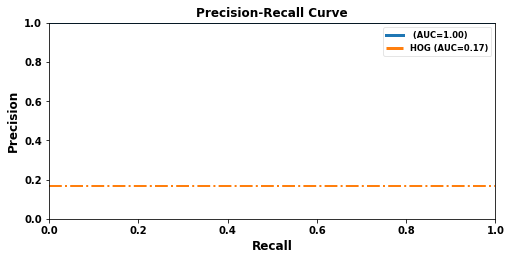

In [55]:
modelpath = PATH
datapath = 'D:\\workspace\\data\\dataset\\06\\test'
#datapath = 'D:\\workspace\\data\\spring_summer'
plot(model,datapath)